# SDA Mini Project (김태훈 60231211)

## data 전처리 부분

In [96]:
# data 전처리

import pandas as pd
import numpy as np

data=pd.read_csv('Data_Science_Fields_Salary_Categorization.csv', index_col=0)
group_mapping = {
    "Data Engineer": [
        "Data Engineer", "Big Data Engineer", "Cloud Data Engineer", "Lead Data Engineer", 
        "Principal Data Engineer", "Data Engineering Manager", "ETL Developer", "Data Architect", 
        "Big Data Architect"
    ],
    "Data Scientist": [
        "Data Scientist", "Applied Data Scientist", "Principal Data Scientist", "Staff Data Scientist", 
        "Research Scientist", "AI Scientist", "Director of Data Science", "Head of Data Science", 
        "Data Science Manager", "Data Science Consultant", "Data Science Engineer"
    ],
    "Machine Learning Engineer": [
        "Machine Learning Engineer", "ML Engineer", "Machine Learning Developer", 
        "Machine Learning Scientist", "Applied Machine Learning Scientist", "Lead Machine Learning Engineer", 
        "Machine Learning Infrastructure Engineer", "Head of Machine Learning", "Machine Learning Manager", 
        "NLP Engineer"
    ],
    "Data Analyst": [
        "Data Analyst", "Business Data Analyst", "BI Data Analyst", "Financial Data Analyst", 
        "Marketing Data Analyst", "Product Data Analyst", "Lead Data Analyst", 
        "Principal Data Analyst", "Data Specialist", "Data Analytics Manager", 
        "Data Analytics Engineer", "Data Analytics Lead", "Analytics Engineer"
    ],
    "Computer Vision Engineer": [
        "Computer Vision Engineer", "3D Computer Vision Researcher", "Computer Vision Software Engineer"
    ]
}

def map_designation(designation):
    for group, titles in group_mapping.items():
        if designation in titles:
            return group
    return 'Other'

data['Group'] = data['Designation'].apply(map_designation)
data=data[data['Group'] != 'Other']
data_copy=data.copy()
data_copy['Salary_In_Rupees']=data['Salary_In_Rupees'].replace(',', '', regex=True).astype(float)
data_copy['Salary_Million_Won']=(data_copy['Salary_In_Rupees']*16.5/1000000).astype(int)
data=data_copy[['Working_Year','Experience','Employment_Status',
           'Employee_Location','Company_Location','Company_Size',
           'Remote_Working_Ratio','Group','Salary_Million_Won']]

# e-03 보다 크다면 과학적 표기법으로 쓰는 것이 아닌 일반 숫자 표시로 나타내도록
def conditional_format(x):
    if abs(x) < 1e-3:
        return f"{x:.3e}"  # 과학적 표기법
    else:
        return f"{x:.6f}"  # 일반 숫자 표시

# Pandas의 표시 형식에 조건부 포매팅 함수 적용
pd.options.display.float_format = conditional_format

## Experience 별로 Salary_Million_Won 의 통계적으로 유의미한 차이가 있는가?

Experience 별로 Salary_Million_Won 의 차이를 구하기 위한 Experience 의 정규성 검정 

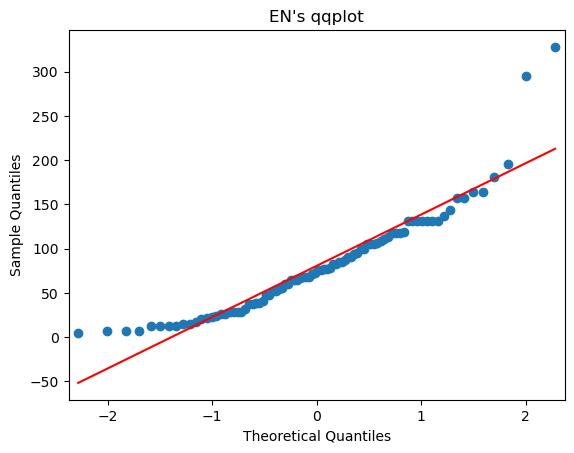

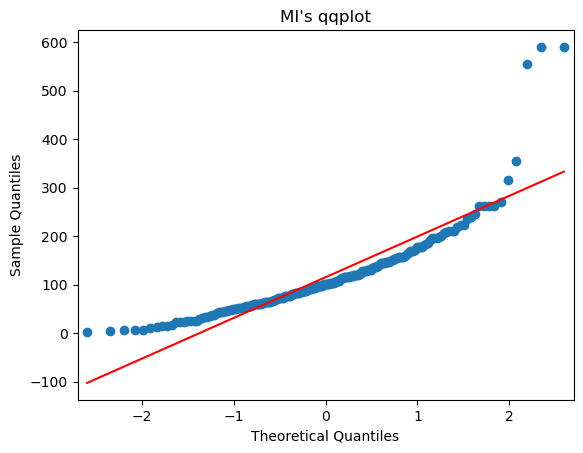

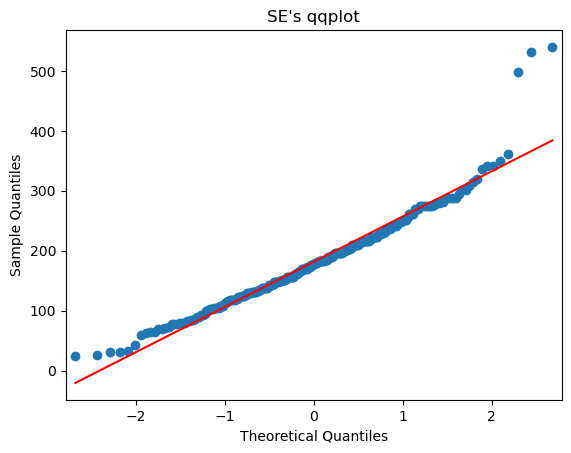

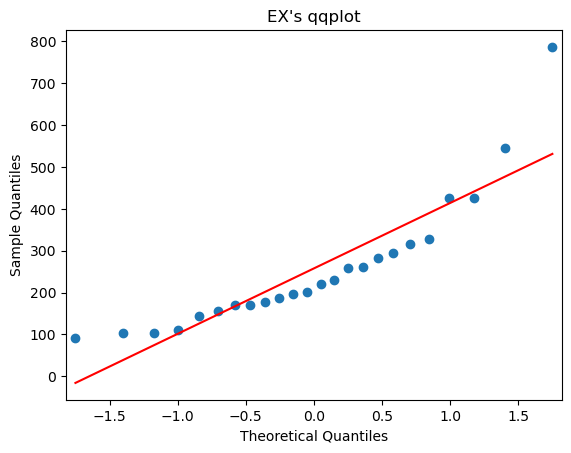

In [18]:
# Experience 별로 Salary_Million_Won 의 차이를 구하기 위한 Experience 의 정규성 검정 (by qqplot)

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Experience 종류 별로 Salary_Million_Won
salary_en = data.loc[data['Experience'] == 'EN', 'Salary_Million_Won']
salary_ex = data.loc[data['Experience'] == 'EX', 'Salary_Million_Won']
salary_mi = data.loc[data['Experience'] == 'MI', 'Salary_Million_Won']
salary_se = data.loc[data['Experience'] == 'SE', 'Salary_Million_Won']

# Entry level의 qqplot
sm.qqplot(salary_en, line = 's')
plt.title("EN's qqplot")
plt.show()

# Mid level의 qqplot
sm.qqplot(salary_mi, line = 's')
plt.title("MI's qqplot")
plt.show()

# Senior level의 qqplot
sm.qqplot(salary_se, line = 's')
plt.title("SE's qqplot")
plt.show()

# Executive level의 qqplot
sm.qqplot(salary_ex, line = 's')
plt.title("EX's qqplot")
plt.show()

In [97]:
# shapiro test를 사용하여 Experience 별 데이터의 정규성 검정

from scipy.stats import shapiro

# Experience의 종류별로 for 반복문을 통해 shapiro test 실행
normality_experience_results = {}
for experience, group_data in data.groupby('Experience'):
    stat, p_value = shapiro(group_data['Salary_Million_Won'])
    normality_experience_results[experience] = {'Shapiro-Wilk Statistic': stat, 'p-value': p_value}


normality_experience_df = pd.DataFrame.from_dict(normality_experience_results, orient='index')
normality_experience_df

,Shapiro-Wilk Statistic,p-value
EN,0.889689,1.808e-06
EX,0.824771,7.702e-04
MI,0.796454,7.172e-16
SE,0.946905,2.208e-08


shapiro test 결과 p-value의 값들이 모두 0.05 보다 작음으로 data가 normal을 따른다는 H0를 reject 할 수 있다.<br>
따라서 각 데이터의 정규성이 보장되어야 하는 ANOVA test 보다 비모수 검정인 Kruskal test를 사용한다.

In [98]:
# kruskal test 시행

from scipy import stats

stats.kruskal(salary_en, salary_ex, salary_mi, salary_se)

KruskalResult(statistic=185.94307007835795, pvalue=4.591160700344653e-40)

Kruskal test 결과 p-value 가 0.05 보다 작음으로 모든 그룹의 중앙값이 같다는 H0 를 reject 할 수 있다. <br>
어떤 pair의 중앙값이 다른지 Dunn's test를 통해서 알아본다. (비모수적 방법)<br>
(tukey HSD test의 경우에는 ANOVA의 사후분석 방법으로 데이터가 정규분포를 따르고 등분산성을 만족하는 경우에만 사용)

In [109]:
# Dunn's test 시행

import scikit_posthocs as sp

# 'Experience'별로 'Salary_Million_Won' 데이터를 그룹화
experience_order = ['EN', 'MI', 'SE', 'EX']
experience_groups = [data.loc[data['Experience'] == exp, 'Salary_Million_Won'] for exp in experience_order]

# Dunn's 검정 실행 (False discovery rate FDR 보정 적용)
dunn_test_experience_results = sp.posthoc_dunn(experience_groups, p_adjust='fdr_bh')

# 결과 행과 열 이름을 Experience 그룹 이름으로 설정
experience_name_groups = experience_order
dunn_test_experience_results.index = experience_name_groups
dunn_test_experience_results.columns = experience_name_groups

# 결과 출력
print(dunn_test_experience_results)

          EN        MI        SE        EX
EN  1.000000  0.001188 4.688e-27 2.707e-13
MI  0.001188  1.000000 2.372e-23 3.527e-09
SE 4.688e-27 2.372e-23  1.000000  0.087506
EX 2.707e-13 3.527e-09  0.087506  1.000000


Experience 별로 Salary_Million_Won 의 통계적으로 유의미한 차이가 있는가?<br>
<br>
Dunn'test 결과 p-value 가 SE 와 EX pair를 제외하고는 다 0.05 보다 작음으로 SE와 EX pair를 제외한 나머지는 모두 <br>
중앙값이 통계적으로 유의미한 차이가 있다고 할 수 있다. 반면 SE와 EX pair는 p-value 가 0.05 보다 큼으로 각각의 중앙값이 통계적으로 유의미한 차이가 있다고 볼 수 없다.
<hr>

## Remote Working Ratio 별로 Salary_Million_Won 의 통계적으로 유의미한 차이가 있는가?

Remote Working Ratio 별로 Salary_Million_Won 의 차이를 구하기 위한 Remote Working Ratio 의 정규성 검정 

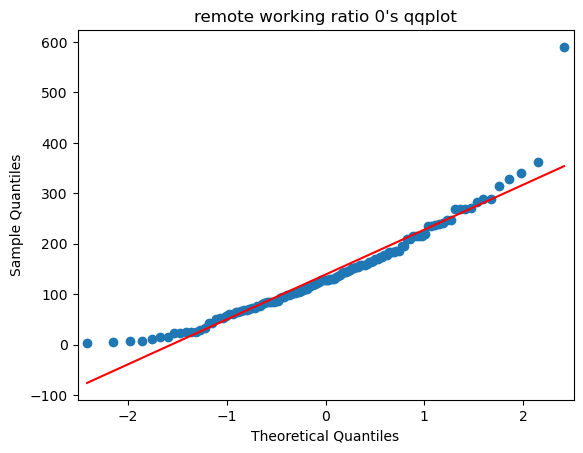

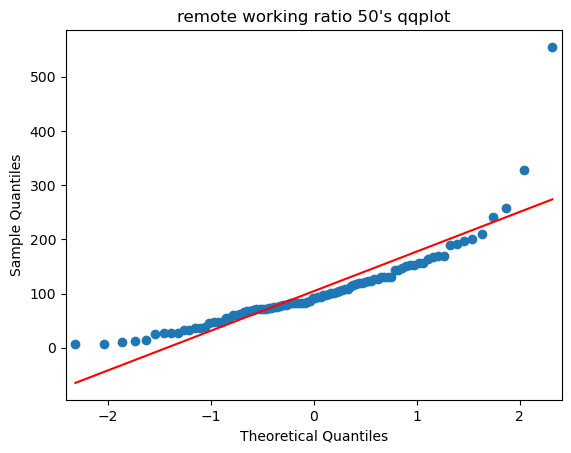

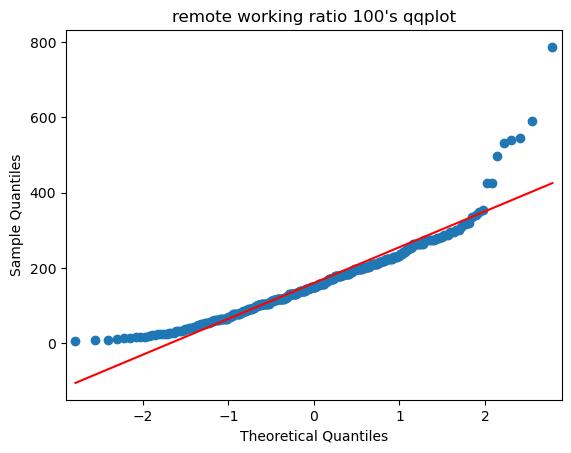

In [35]:
# Remote Working Ratio 별로 Salary_Million_Won 의 차이를 구하기 위한 Experience 의 정규성 검정 (by qqplot)

# Remote Working Ratio 별로 Salary_Million_Won
remote_0 = data.loc[data['Remote_Working_Ratio'] == 0, 'Salary_Million_Won']
remote_50 = data.loc[data['Remote_Working_Ratio'] == 50, 'Salary_Million_Won']
remote_100 = data.loc[data['Remote_Working_Ratio'] == 100, 'Salary_Million_Won']

# Remote Working Ratio == 0 (less than 20%) 의 qqplot
sm.qqplot(remote_0, line = 's')
plt.title("remote working ratio 0's qqplot")
plt.show()

# Remote Working Ratio == 50 (Partially Remote) 의 qqplot
sm.qqplot(remote_50, line = 's')
plt.title("remote working ratio 50's qqplot")
plt.show()

# Remote Working Ratio == 100 (more than 80%) 의 qqplot
sm.qqplot(remote_100, line = 's')
plt.title("remote working ratio 100's qqplot")
plt.show()

In [100]:
# shapiro test를 사용하여 Remote Working Ratio 별 데이터의 정규성 검정

# Remote Working Ratio의 종류별로 for 반복문을 통해 shapiro test 실행
normality_remote_working_results = {}
for ratio, group_data in data.groupby('Remote_Working_Ratio'):
    stat, p_value = shapiro(group_data['Salary_Million_Won'])
    normality_remote_working_results[ratio] = {'Shapiro-Wilk Statistic': stat, 'p-value': p_value}

normality_remote_working_df = pd.DataFrame.from_dict(normality_remote_working_results, orient='index')
normality_remote_working_df

,Shapiro-Wilk Statistic,p-value
0,0.923098,2.231e-06
50,0.791796,2.480e-10
100,0.896265,2.899e-15


shapiro test 결과 p-value의 값들이 모두 0.05 보다 작음으로 data가 normal을 따른다는 H0를 reject 할 수 있다. <br>
따라서 각 데이터의 정규성이 보장되어야 하는 ANOVA test 보다 비모수 검정인 Kruskal test를 사용한다.

In [101]:
# kruskal test 실행

stats.kruskal(remote_0, remote_50, remote_100)

KruskalResult(statistic=39.48991032867225, pvalue=2.659958902829837e-09)

Kruskal test 결과 p-value 가 0.05 보다 작음으로 모든 그룹의 중앙값이 같다는 H0 를 reject 할 수 있다. <br>
따라서 어떤 pair의 중앙값이 다른지 비모수적 사후검정 방법인 Dunn's test를 통해 알아본다.

In [102]:
# Dunn's test 시행

# 'Remote_Working_Ratio'별로 'Salary_Million_Won' 데이터를 그룹화
remote_name_groups = sorted(data['Remote_Working_Ratio'].unique())
remote_groups = [data.loc[data['Remote_Working_Ratio'] == rem, 'Salary_Million_Won'] for rem in remote_name_groups]

# Dunn's 검정 실행 (False discovery rate FDR 보정 적용)
dunn_test_remote_results = sp.posthoc_dunn(remote_groups, p_adjust='fdr_bh')

# 결과 행과 열 이름을 Remote_Working_Ratio 그룹 이름으로 설정
dunn_test_remote_results.index = remote_name_groups
dunn_test_remote_results.columns = remote_name_groups

# 결과 출력
print(dunn_test_remote_results)

          0         50        100
0    1.000000 9.245e-04  0.017012
50  9.245e-04  1.000000 1.660e-09
100  0.017012 1.660e-09  1.000000


Remote Working Ratio 별로 Salary_Million_Won 의 통계적으로 유의미한 차이가 있는가?<br>
<br>
Dunn's test의 결과 p-value가 모두 0.05보다 작음으로 각 pair의 중앙값이 같다는 H0을 reject 할 수 있다. <br>
따라서 Remote_Working_Ratio의 0, 50, 100 모두 중앙값이 유의미한 차이가 있다고 할 수 있다.
<hr>

## Employment Status 별로 Salary_Million_Won 의 통계적으로 유의미한 차이가 있는가?

Employment Status 별로 Salary_Million_Won 의 차이를 구하기 위한 Employment Status 의 정규성 검정 

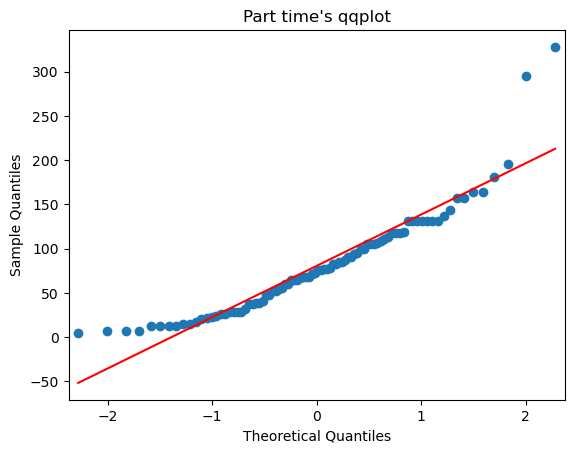

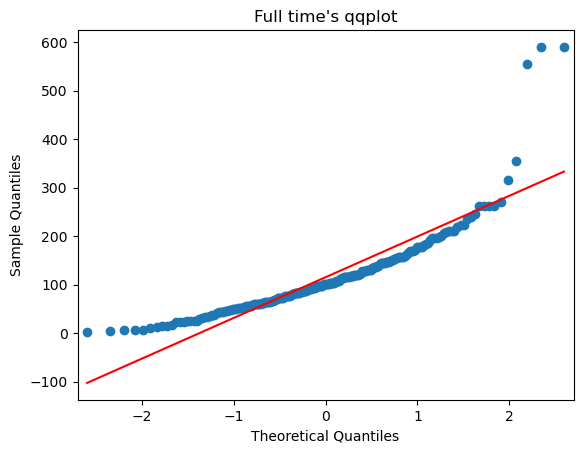

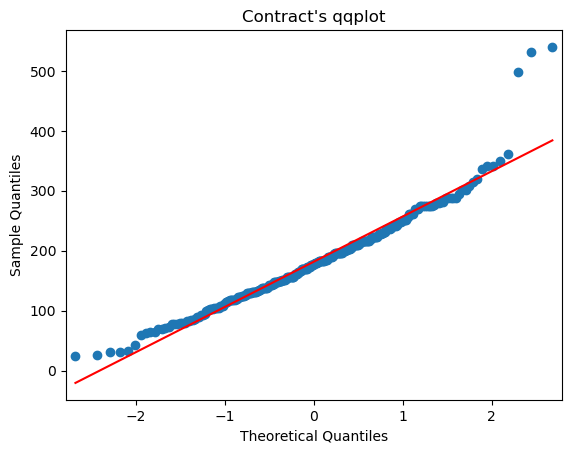

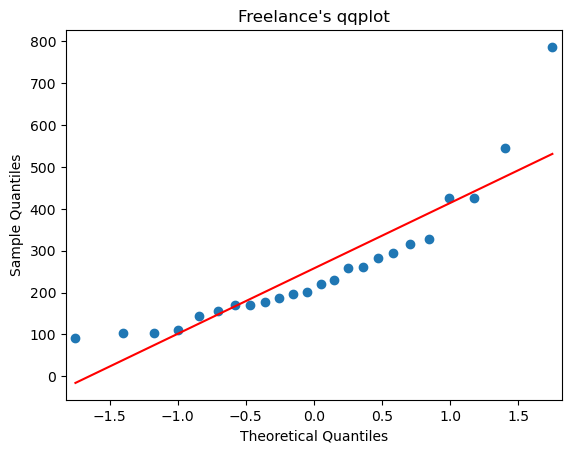

In [110]:
# Employment Status 별로 Salary_Million_Won 의 차이를 구하기 위한 Employment Status 의 정규성 검정 (by qqplot)

# Employment Status 종류 별로 Salary_Million_Won
salary_pt = data.loc[data['Employment_Status'] == 'PT', 'Salary_Million_Won']
salary_ft = data.loc[data['Employment_Status'] == 'FT', 'Salary_Million_Won']
salary_ct = data.loc[data['Employment_Status'] == 'CT', 'Salary_Million_Won']
salary_fl = data.loc[data['Employment_Status'] == 'FL', 'Salary_Million_Won']

# Part time의 qqplot
sm.qqplot(salary_en, line = 's')
plt.title("Part time's qqplot")
plt.show()

# Full time의 qqplot
sm.qqplot(salary_mi, line = 's')
plt.title("Full time's qqplot")
plt.show()

# Contract의 qqplot
sm.qqplot(salary_se, line = 's')
plt.title("Contract's qqplot")
plt.show()

# Freelance의 qqplot
sm.qqplot(salary_ex, line = 's')
plt.title("Freelance's qqplot")
plt.show()

In [131]:
# shapiro test를 사용하여 Employment Status 별 데이터의 정규성 검정

# Employment Status의 종류별로 for 반복문을 통해 shapiro test 실행
normality_status_results = {}
for ratio, group_data in data.groupby('Employment_Status'):
    stat, p_value = shapiro(group_data['Salary_Million_Won'])
    normality_status_results[ratio] = {'Shapiro-Wilk Statistic': stat, 'p-value': p_value}

normality_status_df = pd.DataFrame.from_dict(normality_status_results, orient='index')
normality_status_df

,Shapiro-Wilk Statistic,p-value
CT,0.899098,0.404918
FL,0.916517,0.517600
FT,0.897563,3.457e-19
PT,0.812867,0.020773


shapiro test 결과 CT와 FL은 p-value가 0.05보다 큼으로 정규성을 따른다고 볼 수 있지만 나머지 FT, PT의 p-value가 0.05보다 작음으로 <br>
비모수 검정인 kruskal test를 실행한다.

In [112]:
# kruskal test 실행

stats.kruskal(salary_pt, salary_ft, salary_ct, salary_fl)

KruskalResult(statistic=22.23833721969804, pvalue=5.8190628721980725e-05)

Kruskal test 결과 p-value 가 0.05 보다 작음으로 모든 그룹의 중앙값이 같다는 H0 를 reject 할 수 있다.<br>
따라서 어떤 pair의 중앙값이 다른지 비모수적 사후검정 방법인 Dunn's test를 통해 알아본다.

In [124]:
# Dunn's test 시행

# 'Employment Status'별로 'Salary_Million_Won' 데이터를 그룹화
status_order = ['PT', 'FT', 'CT', 'FL']
status_groups = [data.loc[data['Employment_Status'] == sta, 'Salary_Million_Won'] for sta in status_order]

# Dunn's 검정 실행 (FWER Bonferroni 보정 적용)
dunn_test_status_results = sp.posthoc_dunn(status_groups, p_adjust='fdr_bh')

# 결과 행과 열 이름을 Employment_Status 그룹 이름으로 설정
status_name_groups = status_order
dunn_test_status_results.index = status_name_groups
dunn_test_status_results.columns = status_name_groups

# 결과 출력
print(dunn_test_status_results)

          PT        FT       CT       FL
PT  1.000000 2.062e-04 0.005945 0.658668
FT 2.062e-04  1.000000 0.487787 0.051962
CT  0.005945  0.487787 1.000000 0.051962
FL  0.658668  0.051962 0.051962 1.000000


Employment Status 별로 Salary_Million_Won 의 통계적으로 유의미한 차이가 있는가?<br>

Dunn’s test 결과 PT, FL pair FT, CT pair 를 제외한 나머지 pair 들의 p-value 가 0.05보다 작거나 비슷함으로 중앙값이 통계적으로 유의미한 차이가 있다고 볼 수 있다. <br>
반면 PT, FL pair FT, CT pair 는 p-value 가 0.05보다 큼으로 중앙값이 통계적으로 유의미한 차이가 없다고 볼 수 있다.